# Text analysis on a research paper
***
This is a sample implementation of Natural Language Processing  on a research paper from LCLS[[1]](https://doi.org/10.1073/pnas.1814526116) to explore elements of tokenization, word embeddings and vectorization.  
**The objective** is to analyse the text file to find word associations and identify possible patterns to detect a mention of the facility in the text.  
Adapted from [[2]](https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE/blob/master/Thrones2Vec.ipynb)[[3]](https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html)[[4]](https://github.com/ravishchawla/word_2_vec/blob/master/word_2_vec.ipynb)


In [1]:
#loading libraries 
import multiprocessing
import os
import re
import urllib.request

import nltk
from bs4 import BeautifulSoup
import gensim.models.word2vec as w2v
from sklearn import cluster
from sklearn.neighbors import KDTree
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

%pylab inline

C:\Users\krist\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


## Loading and cleaning text file
We chose one research paper at random from the year 2019, with the sole requirement that it did not mention the facility name in the title or the abstract. We load the HTML file and do some cleaning. **Please note that to access the file in this way requires full permissions to download the research paper. If the word count below is low, you probably don't have access from your network.**

In [2]:
#loading the text html file into text
raw_html = urllib.request.urlopen("https://doi.org/10.1073/pnas.1814526116").read().decode('utf-8')

In [3]:
#cleaning html files with beautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

raw_text = denoise_text(raw_html) #raw_full text without html elements

#identifying research paper within the text string, we do not include the reference list in this example.
start = raw_text.index("Crystal structures of intermediates in the reaction") 
end = raw_text.index("Footnotes↵1")
raw_text = raw_text[start:end]
print("Word Count:",len(raw_text))
print("==================")
print(raw_text)

Word Count: 28232
Crystal structures of intermediates in the reaction of oxygen (O2) with cytochrome c oxidase (CcO) have never been determined, limiting our understanding of the coupling between O2 reduction and proton translocation. With time-resolved serial femtosecond crystallography, the structure of a catalytic intermediate was obtained in the reaction of reduced microcrystals of bovine CcO with O2. This intermediate, identified as the PR species formed in the R → A → PR reaction, is composed of a heme a3 ferryl (Fe4+ = O2−) structure and an electronic configuration of the metal centers of . There is a 120° rotation of the heme a farnesyl side chain in PR, suggesting its role in proton gating in mammalian CcOs.AbstractCytochrome c oxidase (CcO) reduces dioxygen to water and harnesses the chemical energy to drive proton translocation across the inner mitochondrial membrane by an unresolved mechanism. By using time-resolved serial femtosecond crystallography, we identified a key ox

We can use a wordcloud to inspect repeated elements in the full text.

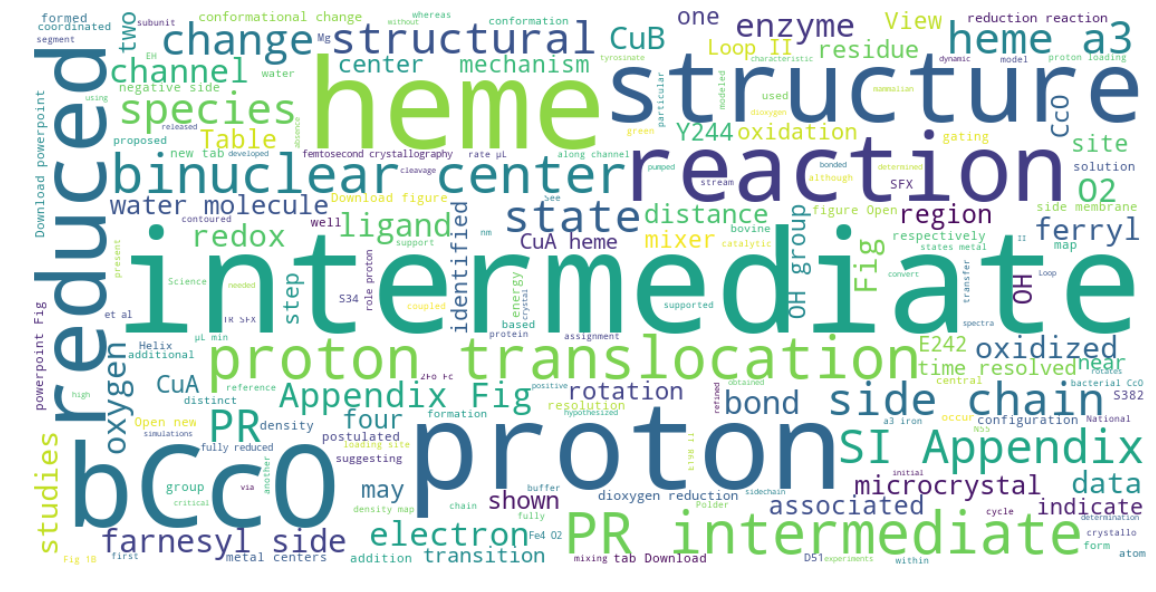

In [4]:
#build the wordcloud with the raw text 
wc = WordCloud(width=1000, height=500, background_color="white");
wordcloud = wc.generate(raw_text)

#plot
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenization 
Next, we tokenize the text into words in sentences. We do some further cleaning, removing unnecessary characters, hyphens, turning into lowercase and removing numbers. 

In [5]:
#separate the raw text into sentences using using a tokenizer from the NLTK library
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(raw_text)

#convert into a list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.lower().split()
    return words

#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
print("Before tokenization:")
print(raw_sentences[0])
print("====================")
print("After tokenization:")
print(sentence_to_wordlist(raw_sentences[0]))
print("====================")
#token count
token_count = sum([len(sentence) for sentence in sentences])
print("The article corpus contains {0:,} tokens in {1:,} sentences".format(token_count,len(sentences)))

Before tokenization:
Crystal structures of intermediates in the reaction of oxygen (O2) with cytochrome c oxidase (CcO) have never been determined, limiting our understanding of the coupling between O2 reduction and proton translocation.
After tokenization:
['crystal', 'structures', 'of', 'intermediates', 'in', 'the', 'reaction', 'of', 'oxygen', 'o', 'with', 'cytochrome', 'c', 'oxidase', 'cco', 'have', 'never', 'been', 'determined', 'limiting', 'our', 'understanding', 'of', 'the', 'coupling', 'between', 'o', 'reduction', 'and', 'proton', 'translocation']
The article corpus contains 4,601 tokens in 196 sentences


## Model 
Word2Vec is a two-layer neural network that processes text as an input into vectors represented in a vector space. It makes the assumption that the meaning of a word can be inferred by the company it keeps. It can help identifying distance, similarity and ranking in words.  
[Link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) to the original paper

In [116]:
# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 50
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length. Words at a time
context_size = 20

# Downsample setting for frequent words.
#between 0 - 1e-5 is good for this
downsampling = 1e-3

# Seed to make the results reproducible.
seed = 42

#model
model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter=25
)

#building vocabulary
model.build_vocab(sentences)

print("Word2Vec vocabulary length:", len(model.wv.vocab))
print("Model summary:", model)

Word2Vec vocabulary length: 926
Model summary: Word2Vec(vocab=926, size=50, alpha=0.025)


In [117]:
#train model
%time model.train(sentences,epochs=model.epochs,total_examples=model.corpus_count)

Wall time: 809 ms


(77195, 115025)

## Dimensionality reduction 
Reducing the dimensionality will allow us to visually inspect the vectors in two dimensions. However, we will use the full model going forward with the analysis. 

In [118]:
#using t-SNE to reduce dimensionality in 2D plane 
#squashes all words (vectors) in two dimensional spaces
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, verbose=1)
all_word_vectors_matrix = model.wv.vectors
#train 
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 926 samples in 0.001s...
[t-SNE] Computed neighbors for 926 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 926 / 926
[t-SNE] Mean sigma: 0.408578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.550667
[t-SNE] KL divergence after 1000 iterations: 0.689818


## Exploring the data

In [119]:
#creating a dataframe 
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [120]:
points.head(10)

,word,x,y
0,crystal,5.336488,16.188318
1,structures,20.769234,5.806130
2,of,2.033884,5.638510
3,intermediates,9.519732,21.790447
4,in,9.989742,-28.417772
5,the,-4.342256,1.985633
6,reaction,5.079289,23.731928
7,oxygen,3.565583,26.567528
8,o,-23.007156,-3.538534
9,with,-23.248617,5.846156


### Visualizing the text in 2D space 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


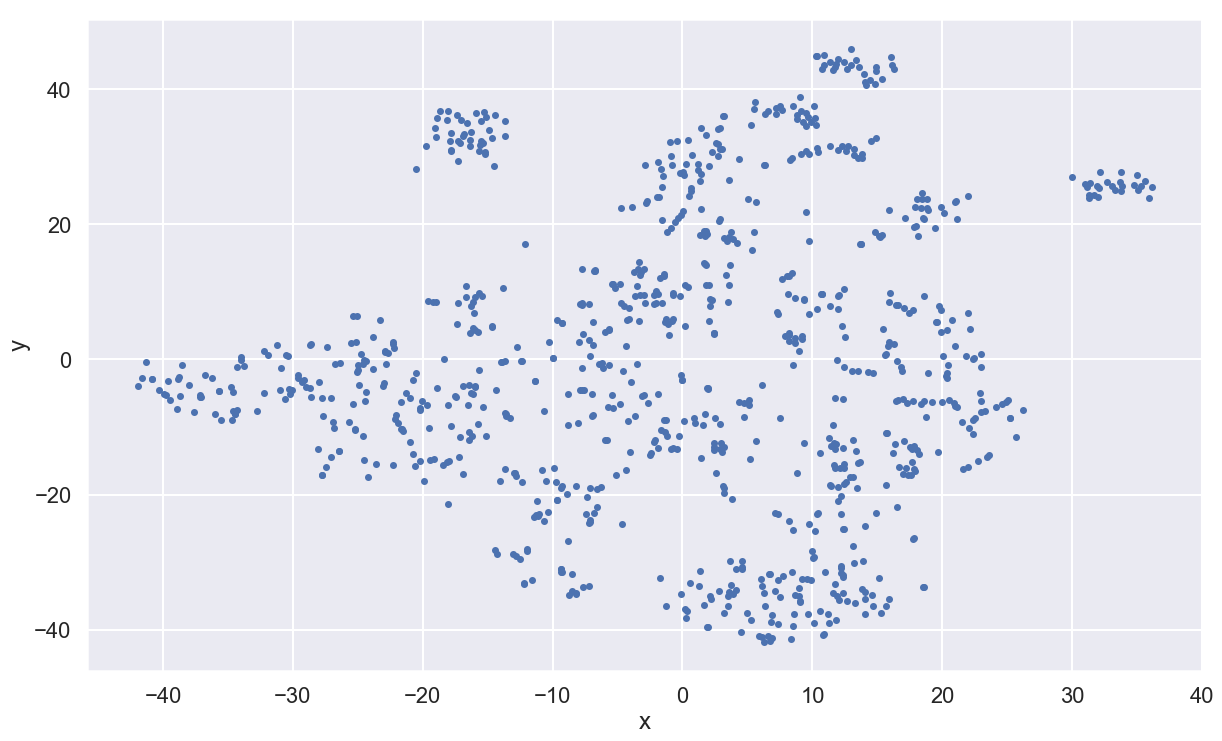

In [121]:
#plotting
sns.set()
sns.set_context("poster")
points.plot.scatter("x", "y", s=25, figsize=(20, 12))

In [122]:
#defining word clusters for later use
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=50, figsize=(20, 12))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.05, point.y + 0.05, point.word, fontsize=25)

We can zoom in on the area of the plot surrounding the word LCLS to see how it appears within the context of the article.

In [123]:
#finding words of interest in the plot
print("Coordinates for keyword: LCLS")
points.loc[points["word"] == "lcls"]

Coordinates for keyword: LCLS


,word,x,y
875,lcls,14.788323,40.811539


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


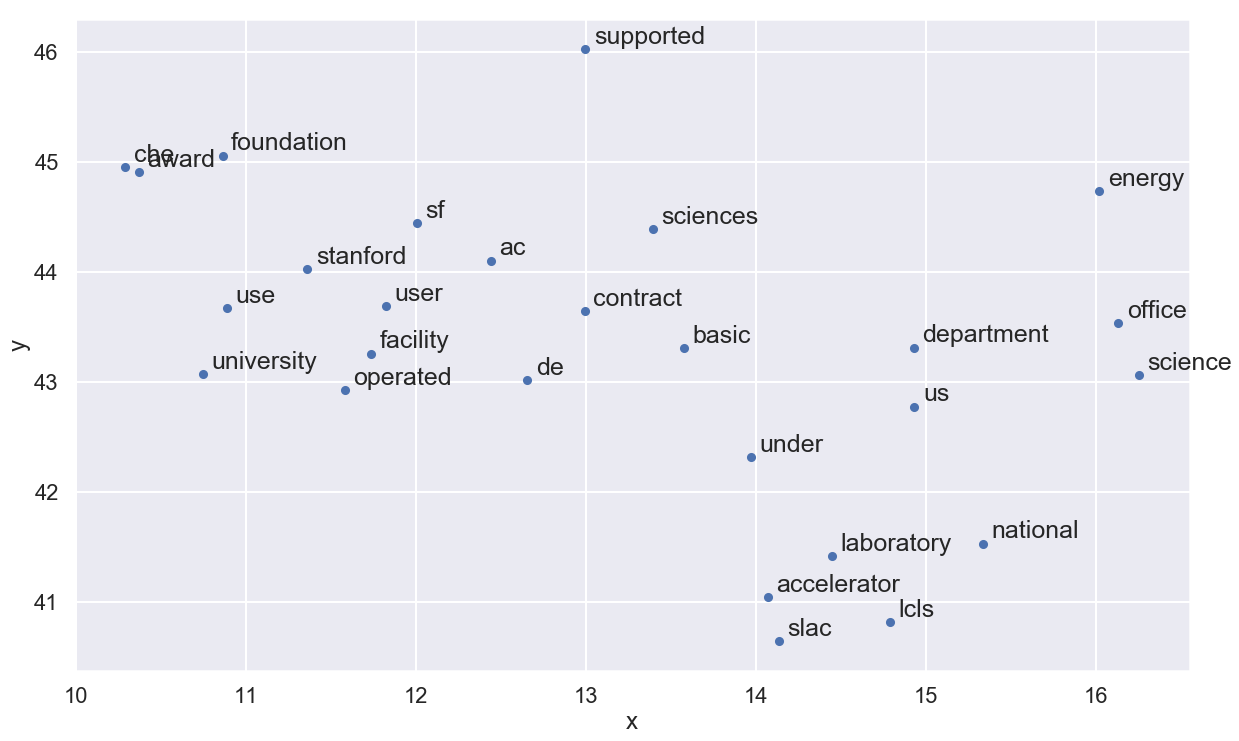

In [128]:
#we can zoom in manually into some regions
#let's zoom into the area of the word LCLS
plot_region(x_bounds=(10,30), y_bounds=(40,50))

We can see words like "laboratory", "accelerator", "national", "slac". Furthermore, we can see other groupings of words that seem to be related to each other.

### Word similarity
After visualizing the model in 2D, we can use the full model to numerically locate similarities (positive *and* negative) between words in the context of the article.

In [129]:
model.wv.most_similar("lcls")#name of the facility where paper was extracted

[('accelerator', 0.9977704286575317),
 ('slac', 0.9976829290390015),
 ('laboratory', 0.9969949126243591),
 ('use', 0.9771825075149536),
 ('national', 0.9767725467681885),
 ('de', 0.972202718257904),
 ('basic', 0.9702023267745972),
 ('us', 0.9676012396812439),
 ('under', 0.9636998772621155),
 ('facility', 0.9627043008804321)]

In [130]:
model.wv.most_similar(negative=["lcls"]) #the least similar words

[('oh', 0.04429829865694046),
 ('group', 0.011697225272655487),
 ('heme', -0.006956636905670166),
 ('when', -0.007580190896987915),
 ('another', -0.03476220369338989),
 ('farnesyl', -0.03588481992483139),
 ('formation', -0.047912657260894775),
 ('during', -0.05037239193916321),
 ('bond', -0.05133660137653351),
 ('eh', -0.05304707586765289)]

In [131]:
model.wv.most_similar("facility")

[('operated', 0.9987824559211731),
 ('user', 0.998558521270752),
 ('stanford', 0.9965092539787292),
 ('contract', 0.9960646629333496),
 ('ac', 0.9957882761955261),
 ('de', 0.9956880211830139),
 ('basic', 0.9950642585754395),
 ('sf', 0.9950382709503174),
 ('use', 0.9913332462310791),
 ('us', 0.990119218826294)]

In [132]:
model.wv.most_similar("user")

[('facility', 0.998558521270752),
 ('operated', 0.9981508255004883),
 ('contract', 0.9968518614768982),
 ('stanford', 0.996208131313324),
 ('basic', 0.9958404302597046),
 ('ac', 0.9957351088523865),
 ('sf', 0.9953190088272095),
 ('de', 0.9949266314506531),
 ('us', 0.9921599626541138),
 ('department', 0.9917277693748474)]

In [133]:
model.wv.most_similar("experiments")

[('macromolecular', 0.9571011066436768),
 ('helium', 0.9468380212783813),
 ('station', 0.9456585645675659),
 ('experimental', 0.9447605609893799),
 ('light', 0.9417023658752441),
 ('system', 0.941129744052887),
 ('rich', 0.9399113059043884),
 ('bruce', 0.939476728439331),
 ('doak', 0.9381769895553589),
 ('linac', 0.9380961656570435)]

In [134]:
print(model.wv.similarity("lcls","user"))
print(model.wv.similarity("facility","lcls"))

0.959817024160925
0.962704269554089


In [135]:
#we can use the model to find words that do not fall into the same category
model.wv.doesnt_match("lcsl user facility".split())

'facility'

It would seem that in the context of this article that the word user and the word lcsl have more in common with each other than the word facility.

## KMeans clustering
Cluster analysis grouops a set of objects that are more similar, in some sense, than those in the other groups. The [**k-means**](https://scikit-learn.org/stable/modules/clustering.html#k-means) algorithm clusters data by trying to separate samples in *n* groups of equal variance. It requires the number of clusters to be defined by the user.  

In [136]:
#building training data
X = model.wv[model.wv.vocab]
print("Shape of the model, vocabulary size and feature size we defined earlier")
X.shape

Shape of the model, vocabulary size and feature size we defined earlier


(926, 50)

In [157]:
#we calculate the model with Sklearn with our defined number of clusters
NUM_CLUSTERS=5
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = cluster.KMeans(n_clusters = num_clusters,n_init=50,n_jobs=-1);
    idx = kmeans_clustering.fit_predict(word_vectors)
  
    return kmeans_clustering.cluster_centers_, idx

centers, clusters = clustering_on_wordvecs(X, NUM_CLUSTERS)
centroid_map = dict(zip(model.wv.index2word, clusters))

In [158]:
#build a function to get the top words surrounding each cluster
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df

First we can print out a sample of words that have been associated with each cluster. 

In [159]:
top_words = get_top_words(model.wv.index2word, 10, centers, X);
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05
1,undergoes,fo,user,sites,channels
2,carboxyl,share,copper,storage,relative
3,same,pear,light,vide,used
4,supporting,strong,contract,closer,valve
5,construct,oxidative,station,open,intervening
6,human,designed,experimental,moves,translocate
7,hybrid,response,institute,faster,contains
8,environment,shimada,planck,reduction,location
9,elementary,opening,ac,office,three
10,controversial,altered,source,ligation,free


We can use the word cloud again to visualize the clusters. 

Cluster #1


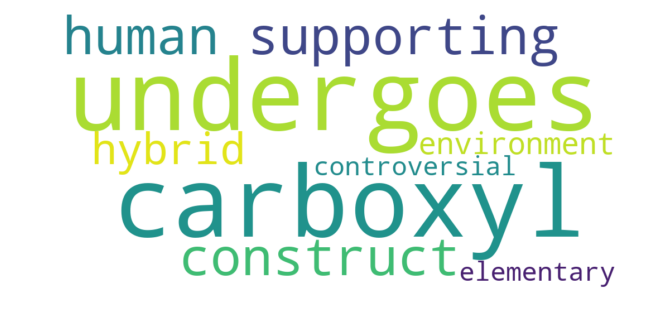

Cluster #2


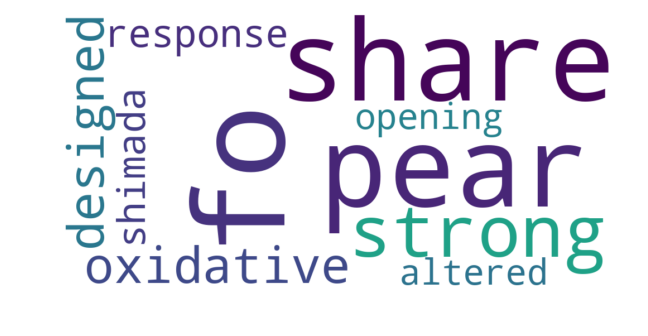

Cluster #3


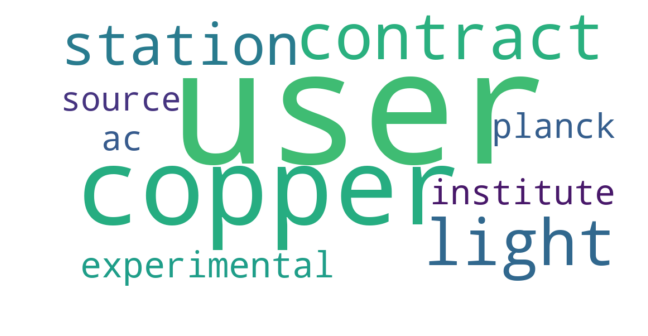

Cluster #4


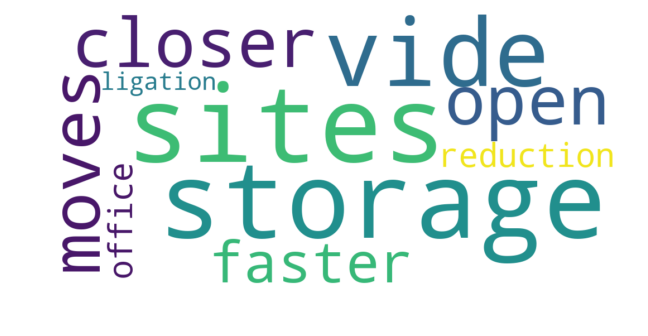

Cluster #5


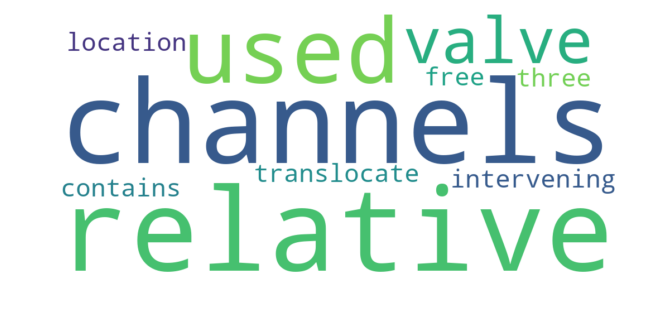

In [160]:
def display_cloud(cluster_num):
    wc = WordCloud(width=1000, height=500,background_color="white");
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

for i in range(NUM_CLUSTERS):
    print(str('Cluster #' + str(i+1)))
    display_cloud(i+1)

Since we are only analysing one paper, the method does not provide a lot of new information. Still, it is interesting to see how the algorithm clusters the different groups together. Perhaps it will identify some interesting patterns with more text from different sources.